In [1]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Helper functions

In [4]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Loading data

In [5]:
data_folder = "../../Data"
structured_data_folder = data_folder + "/structured_data"
text_path = data_folder + "/text"
data_path = structured_data_folder + "/test.csv"
dist_folder = structured_data_folder + "/filtered_Distances"
figure_folder = "../Figures/Results/Embeddings"
model_folder = "../Models/Embeddings"
matches = pd.read_csv(structured_data_folder + "/Matches/Bas3.csv", index_col=0)
figure_folder = "../Figures/Results/Classic"

In [6]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

In [7]:
all_data = distances[distances['permission_indx'].isin(matches["permission_indx"].unique())]
all_data["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        all_data.loc[indx, "Match"] = 1
data = all_data.iloc[:, 3:-1]
y = all_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

<ipython-input-7-e521af8c2916>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data["Match"] = 0
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [8]:
d = distances
d = d[d["SlaafNaamNieuw"] > 0.3]
d = d[d["SlaafGender"] > 0.3]
d = d[d["BezitterAchternaam"] > 0.1]
d = d[d["BezitterVoornaam"] > 0.6]
d

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit
173655,173655,24,1143,True,0.600098,True,1.000000,0.0,0.142822,0.000000,0.0,0.0
185629,185629,26,5933,True,1.000000,True,0.799805,0.0,0.142822,0.000000,0.0,0.0
196131,196131,28,2057,True,0.555664,True,1.000000,0.0,0.199951,0.199951,0.0,0.0
203319,203319,29,2057,True,0.555664,True,1.000000,0.0,0.199951,0.199951,0.0,0.0
216328,216328,31,688,True,1.000000,True,0.636230,0.0,0.142822,0.115356,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26591775,219003,3883,3365,True,0.399902,True,1.000000,0.0,0.272705,0.125000,0.0,0.0
26598762,225990,3884,3164,True,1.000000,True,0.866699,0.0,0.500000,0.000000,0.0,0.0
26598809,226037,3884,3211,True,0.399902,True,0.866699,0.0,0.500000,0.000000,0.0,0.0
26600335,227563,3884,4738,True,0.333252,True,0.866699,0.0,0.500000,0.000000,0.0,0.0


In [9]:
sample1 = all_data[all_data["Match"] == 0].sample(60)
sample2 = all_data[all_data["Match"] == 1].sample(60)

sample = pd.concat([sample1, sample2])
y = sample["Match"]

In [10]:
def plot_decision_boundary(X, y, model, model_name="Default_model", ax_labels=('x', 'y'), colors = ("b", "r"), labels=("non-matches", "matches")):
    clf = model.fit(X, y)

    fig, ax = plt.subplots()
    # title for the plots
    title = (f'Decision surface of {model_name}')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    for i in range(0, 2):
        mask = (y == i)
        tX = X[mask]
        ty = y[mask]
        X0, X1 = tX[:, 0], tX[:, 1]
        ax.scatter(X0, X1, c=colors[i], s=20, edgecolors='k', label=labels[i])
    ax.set_ylabel(f'Owner {ax_labels[1]} similarity')
    ax.set_xlabel(f'{ax_labels[0]} similarity')

    ax.set_title(title)
    ax.legend()
    plt.savefig(figure_folder + f"Decision_boundary_{model_name}.png")
    plt.show()

In [11]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

X = sample.iloc[:, 3:-1][["SlaafNaamNieuw", "BezitterVoornaam"]].values

# model = svm.SVC(kernel='linear')
# model = KNeighborsClassifier(n_neighbors=1)
# model = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False))
# model = make_pipeline(StandardScaler(),svm.SVC())
# model = AdaBoostClassifier(n_estimators=100, random_state=0)

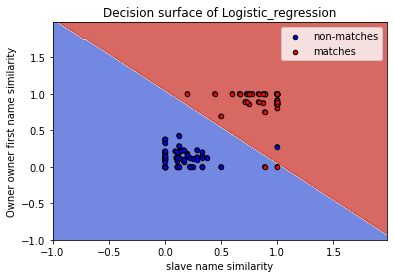

In [12]:
plot_decision_boundary(X, y, make_pipeline(StandardScaler(), LogisticRegressionCV()), "Logistic_regression", ("slave name", "owner first name"))

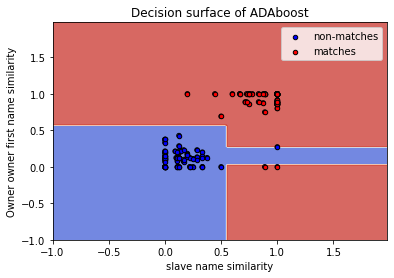

In [13]:
plot_decision_boundary(X, y, make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=30, random_state=0)), "ADAboost", ("slave name", "owner first name"))

C:\Users\basvd\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


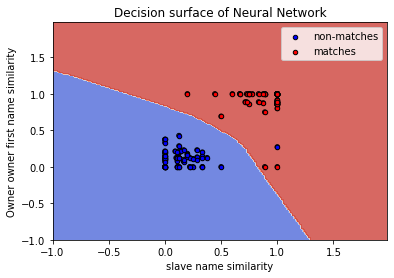

In [14]:
plot_decision_boundary(X, y, make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False)), "Neural Network", ("slave name", "owner first name"))

In [15]:
Classifiers = dict()

# Normalizing data

In [16]:
print("X: ", X_train.shape)
print("y: ", y_train.shape)

X:  (1881818, 9)
y:  (1881818,)


# Blocking

In [17]:
print(f"{X_train.shape[0]} rows before blocking")

1881818 rows before blocking


In [18]:
mask = (X_train["SlaafNaamNieuw"] > 0.3) & (X_train["SlaafGender"] > 0.1) & (X_train["BezitterAchternaam"] > 0.1) & (X_train["BezitterVoornaam"] > 0.1)

In [19]:
X_train = X_train[mask]
y_train = y_train[mask]

In [20]:
print(f"{X_train.shape[0]} rows after blocking")

40961 rows after blocking


In [21]:
X_train = X_train.to_numpy().astype(float)
y_train = y_train.to_numpy().astype(float)

X_test = X_test.to_numpy().astype(float)
y_test = y_test.to_numpy().astype(float)

# Rule based

In [22]:
class Rule_based_classifier():
    def __init__(self, alg):
        self.alg = alg
        
    def predict_proba(self, X_test):
        pred = self.alg(X_test)
        return pred
    
    def predict(self, X_test, thresh):
        pred = self.alg(X_test)
        return (pred >= thresh).astype(float)

## Exact match

In [23]:
def exact_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x == 1.).sum())
    return np.array(pred)/X_test.shape[1]

In [24]:
EM = Rule_based_classifier(exact_match)
pred = EM.predict(X_test, 0.5)

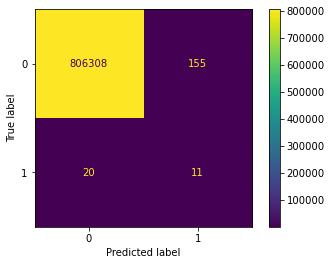

recall score:  0.3548387096774194
precision score:  0.06626506024096386
f1 score:  0.11167512690355332


In [25]:
evaluate_prediction(pred, y_test, model_name = "Exact Match")

In [26]:
Classifiers["Exact Match"] = EM

# Fuzzy match

In [27]:
def fuzzy_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x > 0.1).sum())
    return np.array(pred)/X_test.shape[1]

In [28]:
FM = Rule_based_classifier(fuzzy_match)
pred = FM.predict(X_test, 1.)

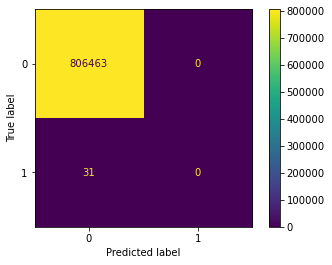

recall score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:  0.0
f1 score:  0.0


In [29]:
evaluate_prediction(pred, y_test, model_name = "Fuzzy Match")

In [30]:
Classifiers["Fuzzy Match"] = FM

# All 0

In [31]:
pred = np.zeros(len(y_test))
pred

array([0., 0., 0., ..., 0., 0., 0.])

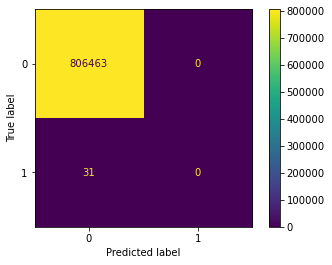

recall score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:  0.0
f1 score:  0.0


In [32]:
evaluate_prediction(pred, y_test, model_name="All 0")

# K nearest neighbors

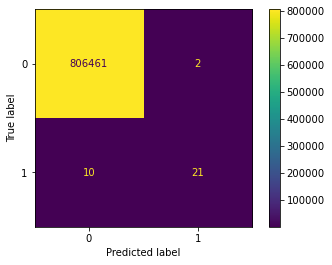

recall score:  0.6774193548387096
precision score:  0.9130434782608695
f1 score:  0.7777777777777777


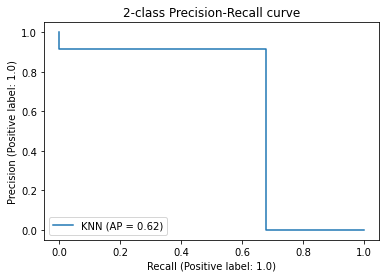

In [33]:
from sklearn.neighbors import KNeighborsClassifier
KNNClf = fit_and_test_classifier(KNeighborsClassifier(n_neighbors=1), X_train, X_test, y_train, y_test, model_name="KNN", figure_folder=figure_folder)

Classifiers["KNeigbors classifier"] = KNNClf

# Logistic regression

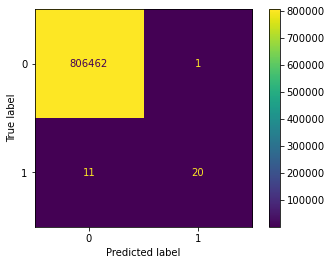

recall score:  0.6451612903225806
precision score:  0.9523809523809523
f1 score:  0.7692307692307692


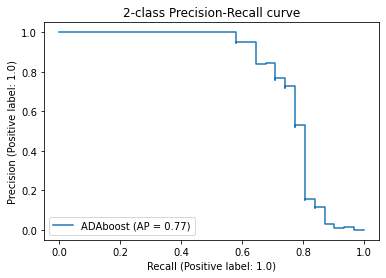

In [34]:
est = make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=30, random_state=0))
LGClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="ADAboost", figure_folder=figure_folder)

Classifiers["Logistic Regression"] = LGClf

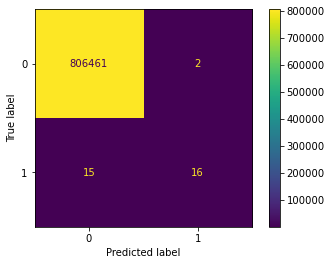

recall score:  0.5161290322580645
precision score:  0.8888888888888888
f1 score:  0.6530612244897959


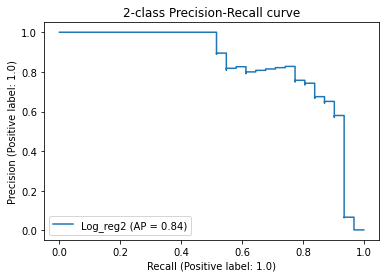

In [35]:
est = make_pipeline(StandardScaler(), LogisticRegressionCV(scoring='f1'))
LGClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="Log_reg2", figure_folder=figure_folder)

Classifiers["Logistic Regression"] = LGClf

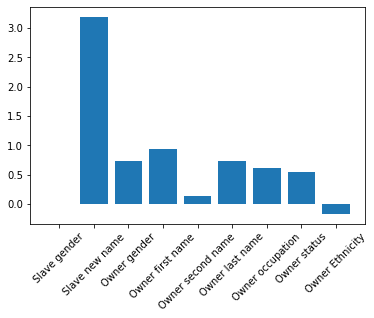

In [36]:
fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
langs = data.columns
langs = ["Slave gender", "Slave new name", "Owner gender", "Owner first name", "Owner second name", "Owner last name", "Owner occupation", "Owner status", "Owner Ethnicity"]
students = LGClf.steps[1][1].coef_[0]
plt.bar(langs,students)
plt.xticks(rotation = 45)
plt.savefig(figure_folder + "Coefs.jpg")
plt.show()

# Naive Bayes

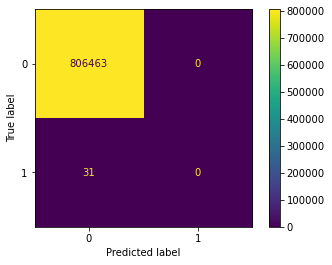

recall score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:  0.0
f1 score:  0.0


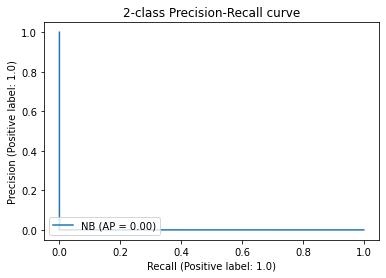

In [37]:
from sklearn.naive_bayes import MultinomialNB

est = make_pipeline(Normalizer(), MultinomialNB())
NBClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="NB", figure_folder=figure_folder)

Classifiers["Naive Bayes"] = NBClf

# Neural Network

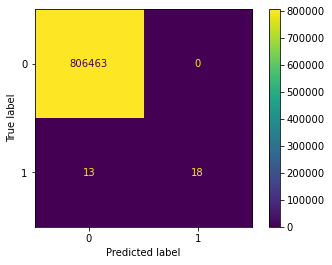

recall score:  0.5806451612903226
precision score:  1.0
f1 score:  0.7346938775510204


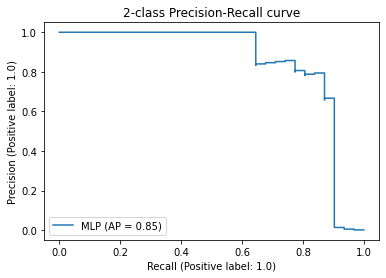

In [38]:
est = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False))

NNClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="MLP", figure_folder=figure_folder)
Classifiers["Neural network"] = NNClf

Exact Match: ROC AUC=0.978
Fuzzy Match: ROC AUC=0.946
KNeigbors classifier: ROC AUC=0.839
Logistic Regression: ROC AUC=1.000
Naive Bayes: ROC AUC=0.926
Neural network: ROC AUC=0.998
No Skill: ROC AUC=0.500


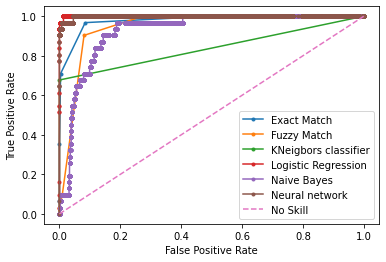

In [39]:
for name in Classifiers:
    model = Classifiers[name]
#     print("name:", name)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
#     print("lr_probs", lr_probs)
    if type(lr_probs[0]) == np.ndarray:
        lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(name + ': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label=name)
    
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
print('No Skill: ROC AUC=%.3f' % (ns_auc))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()